# Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images
Reproduce Results of [Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images](https://pubmed.ncbi.nlm.nih.gov/30094778/)


> We used a pre-trained CNN to extract features based on B-mode images. Next, using the neural features, we employed the support vector machine (SVM) algorithm to classify images containing fatty liver. Aside of fatty liver classification, it is clinically relevant to quantify the grade of liver steatosis. For this task, we used the extracted features and the Lasso regression method. In both cases, liver biopsy results served as a reference. The performance of the pro- posed approach was compared with the GLCM methods.





In [1]:
from scipy.io import loadmat
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from kymatio.torch import Scattering2D
import kymatio.datasets as scattering_datasets
import pickle

In [2]:
with open('../data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle', 'rb') as handle:
    df = pickle.load(handle)

## Extract Features
In this section, scattering and GLCM features will be extracted. 

### Step 3.1 Extract Scattering Features using Kymatio

In [3]:
M, N= 434, 636 # ultrasound image dimension

In [4]:
# Reshape the data appropriately
data = df['img'].iloc[0].view(1,M,N)
for i in tqdm(range(1,len(df['img']))):
    data = torch.cat([data,df['img'].iloc[i].view(1,M,N)])

100%|██████████| 549/549 [00:27<00:00, 19.89it/s]


In [5]:
%%time
# This should take about 7 minutes. It processes about 10 images/5sec.
# Set the parameters of the scattering transform.
J = 2
M, N = 434, 636 #( shape of the ultrasound images)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define a Scattering2D object.
scattering = Scattering2D(J, (M, N))
if use_cuda: scattering = scattering.cuda()

data = data.to(device)
scattering_features = scattering(data)

CPU times: user 31.8 s, sys: 5.15 s, total: 36.9 s
Wall time: 1min


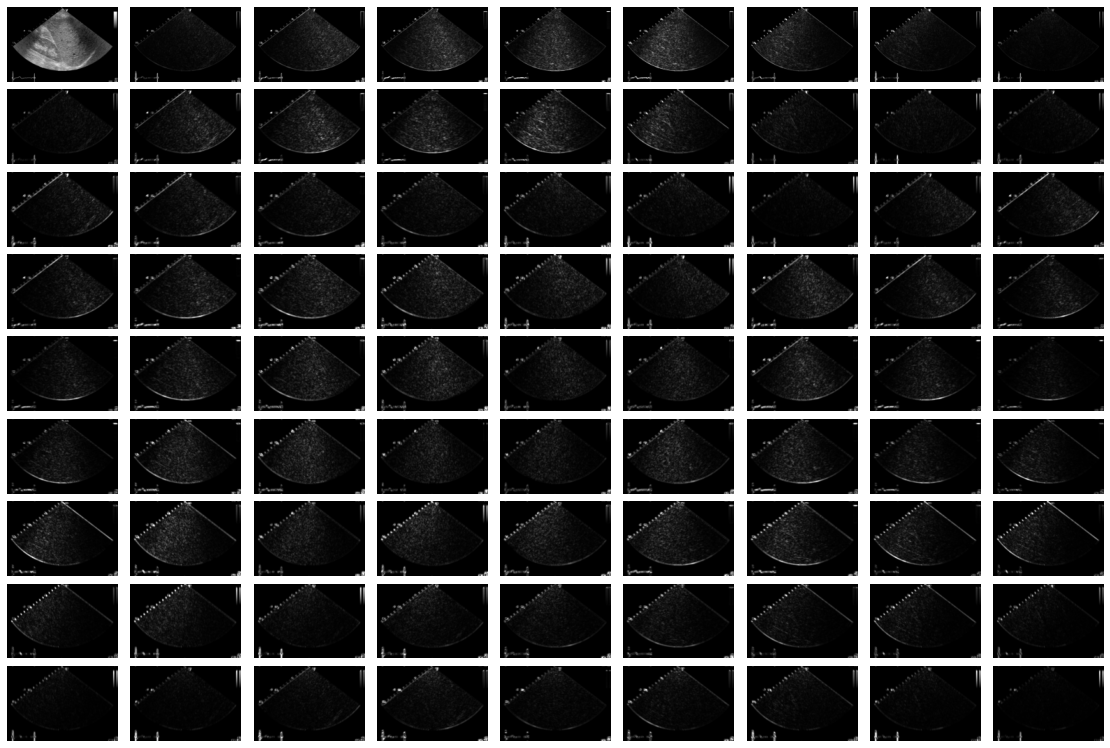

In [6]:
# show images
sf = scattering_features[0].view(scattering_features.shape[1],scattering_features.shape[2], scattering_features.shape[3]).cpu()
npimg = np.uint8(sf)

f, axarr = plt.subplots(9,9, figsize=(scattering_features.shape[3]/8, scattering_features.shape[2]/8))
count = 0
for i in range(0, 9) :
    for j in range(0, 9) :
        axarr[i,j].imshow(sf[count], cmap='gray')
        axarr[i,j].axis('off')
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

#### Save scattering features

In [7]:
sc_features = scattering_features.view(scattering_features.shape[0], scattering_features.shape[1] * scattering_features.shape[2] * scattering_features.shape[3])
X = sc_features.cpu().numpy()
df_sc = pd.DataFrame(X)
df_scattering = pd.concat([df['id'], df['class'], df_sc], axis=1)
df_scattering.shape

(550, 1390934)

In [8]:
# Create a dict for the scattering features, and parameters - for model not using tensors
scatter_dict = {'df':df_scattering,
                'J':J,
                'M':M,
                'N':N}

with open('../data/03_features/scattering_features.pickle', 'wb') as handle:
    pickle.dump(scatter_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Create a dict for the scattering features, and parameters
scatter_dict_tensor = {
                'features':scattering_features,
                'label' : df['class'],
                'pid' : df['id'],
                'J':J,
                'M':M,
                'N':N}

with open('../data/03_features/scatter_dict_tensor.pickle', 'wb') as handle:
    pickle.dump(scatter_dict_tensor, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
